# Hi :)

----

# Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Initialization

In [2]:
# Function to create a bootstrap sample from training data
def bootstrap_sample(X, y):
    return resample(X, y, replace= True, n_samples= len(y), random_state= None)

# Majority voting function
def majority_vote(predictions):
    """
    predictions: list of np.array, each with predicted labels
    returns: np.array of majority voted predictions
    """
    preds_stack= np.vstack(predictions)
    majority_pred, _= mode(preds_stack, axis= 0)
    return majority_pred.ravel()

def weighted_majority_voting(predictions, weights):
    """
    predictions: numpy array of shape (n_classifiers, n_samples)
    weights: numpy array of shape (n_classifiers, ) or (n_classifiers, 1)
    """
    weights= np.array(weights).reshape(-1, 1)  # Ensure shape compatibility
    classes= np.unique(predictions)
    
    # Accumulate weighted votes for each class
    vote_scores= {cls : np.sum((predictions == cls) * weights, axis= 0) for cls in classes}
    
    # Stack scores to shape (n_classes, n_samples), then take argmax
    all_scores= np.vstack([vote_scores[cls] for cls in sorted(classes)])  # shape: (n_classes, n_samples)
    
    final_preds= np.argmax(all_scores, axis= 0)
    return final_preds

# ITG

# Loading the dataset

In [3]:
ITG_features_df= pd.read_csv('Dataset/ITG_features_df.csv')

# Bagging + Majority voting

In [4]:
# Step 1: Extract features and labels
X= ITG_features_df[['F1_sum_vector_magnitude', 'F2_orientation_angle', 'F3_std_magnitude']].values
y= ITG_features_df['Situation'].values

# Step 2: Encode labels ('Fall' → 1, 'Not Fall' → 0)
label_encoder= LabelEncoder()
y_encoded= label_encoder.fit_transform(y)

# Step 3: Split dataset
X_train, X_test, y_train, y_test= train_test_split(X, y_encoded, test_size= 0.2, random_state= 48, stratify= y_encoded)

In [5]:
# Step 4: Train Bagging
# Define base classifiers with chosen hyperparameters
svm_clf= SVC(kernel= 'rbf', C= 100, gamma= 1, random_state= 48)
rf_clf= RandomForestClassifier(
    n_estimators= 200,
    max_depth= 10,
    min_samples_split= 2,
    min_samples_leaf= 1,
    random_state= 48
)
xgb_clf= XGBClassifier(
    n_estimators= 100,
    max_depth= 5,
    learning_rate= 0.1,
    subsample= 0.8,
    objective= 'binary:logistic',
    use_label_encoder= False,
    eval_metric= 'logloss',
    random_state= 48
)

# Bootstrap sampling and training for each classifier
X_svm, y_svm= bootstrap_sample(X_train, y_train)
svm_clf.fit(X_svm, y_svm)

X_rf, y_rf= bootstrap_sample(X_train, y_train)
rf_clf.fit(X_rf, y_rf)

X_xgb, y_xgb= bootstrap_sample(X_train, y_train)
xgb_clf.fit(X_xgb, y_xgb)

f:\Quera\Qvenv\lib\site-packages\xgboost\training.py:183: UserWarning: [20:14:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [6]:
# Step 5: Evaluation
# Predict test set for each classifier
y_pred_svm= svm_clf.predict(X_test)
y_pred_rf= rf_clf.predict(X_test)
y_pred_xgb= xgb_clf.predict(X_test)

# Combine predictions by majority vote
y_pred_ensemble= majority_vote([y_pred_svm, y_pred_rf, y_pred_xgb])

# Calculating the weights for weighted majority vote
weights= [accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)]
# Combine predictions by weighted majority vote
y_pred_ensemble_weighted= weighted_majority_voting([y_pred_svm, y_pred_rf, y_pred_xgb], weights)

Majority vote

Accuracy: 0.675727229375298
Classification Report:
               precision    recall  f1-score   support

        Fall       0.67      0.69      0.68      2097
    Not Fall       0.68      0.66      0.67      2097

    accuracy                           0.68      4194
   macro avg       0.68      0.68      0.68      4194
weighted avg       0.68      0.68      0.68      4194



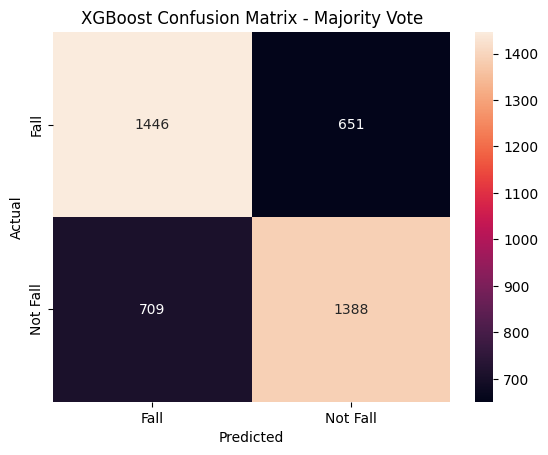

In [7]:
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble, target_names= label_encoder.classes_))

# Confusion Matrix
cm= confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot= True, fmt= 'd', xticklabels= label_encoder.classes_, yticklabels= label_encoder.classes_)
plt.title("XGBoost Confusion Matrix - Majority Vote")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Weighted majority vote

Accuracy: 0.675727229375298
Classification Report:
               precision    recall  f1-score   support

        Fall       0.67      0.69      0.68      2097
    Not Fall       0.68      0.66      0.67      2097

    accuracy                           0.68      4194
   macro avg       0.68      0.68      0.68      4194
weighted avg       0.68      0.68      0.68      4194



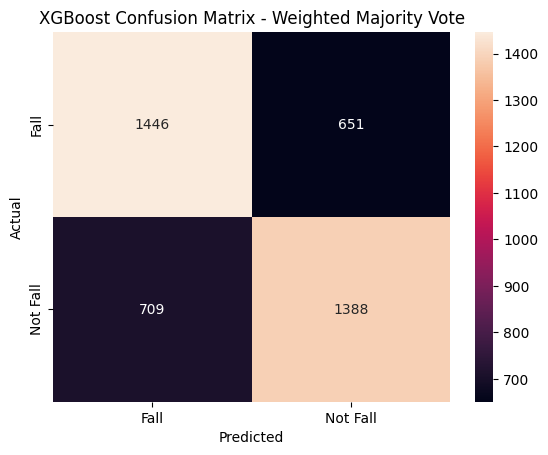

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble_weighted))
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble_weighted, target_names= label_encoder.classes_))

# Confusion Matrix
cm= confusion_matrix(y_test, y_pred_ensemble_weighted)
sns.heatmap(cm, annot= True, fmt= 'd', xticklabels= label_encoder.classes_, yticklabels= label_encoder.classes_)
plt.title("XGBoost Confusion Matrix - Weighted Majority Vote")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

----

# Data Fusion

# Loading the dataset

In [9]:
KF_features_df= pd.read_csv('Dataset/KF_features_df.csv')

# Bagging + Majority voting

In [10]:
# Step 1: Extract features and labels
X= KF_features_df[['F1_sum_vector_magnitude', 'F2_orientation_angle', 'F3_std_magnitude']].values
y= KF_features_df['Situation'].values

# Step 2: Encode labels ('Fall' → 1, 'Not Fall' → 0)
label_encoder= LabelEncoder()
y_encoded= label_encoder.fit_transform(y)

# Step 3: Split dataset
X_train, X_test, y_train, y_test= train_test_split(X, y_encoded, test_size= 0.2, random_state= 48, stratify= y_encoded)

In [11]:
# Step 4: Train Bagging
# Define base classifiers with chosen hyperparameters
svm_clf= SVC(kernel= 'rbf', C= 100, gamma= 1, random_state= 48)
rf_clf= RandomForestClassifier(
    n_estimators= 200,
    max_depth= 10,
    min_samples_split= 2,
    min_samples_leaf= 1,
    random_state= 48
)
xgb_clf= XGBClassifier(
    n_estimators= 100,
    max_depth= 5,
    learning_rate= 0.1,
    subsample= 0.8,
    objective= 'binary:logistic',
    use_label_encoder= False,
    eval_metric= 'logloss',
    random_state= 48
)

# Bootstrap sampling and training for each classifier
X_svm, y_svm= bootstrap_sample(X_train, y_train)
svm_clf.fit(X_svm, y_svm)

X_rf, y_rf= bootstrap_sample(X_train, y_train)
rf_clf.fit(X_rf, y_rf)

X_xgb, y_xgb= bootstrap_sample(X_train, y_train)
xgb_clf.fit(X_xgb, y_xgb)

f:\Quera\Qvenv\lib\site-packages\xgboost\training.py:183: UserWarning: [20:17:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
# Step 5: Evaluation
# Predict test set for each classifier
y_pred_svm= svm_clf.predict(X_test)
y_pred_rf= rf_clf.predict(X_test)
y_pred_xgb= xgb_clf.predict(X_test)

# Combine predictions by majority vote
y_pred_ensemble= majority_vote([y_pred_svm, y_pred_rf, y_pred_xgb])

# Calculating the weights for weighted majority vote
weights= [accuracy_score(y_test, y_pred_svm), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)]
# Combine predictions by weighted majority vote
y_pred_ensemble_weighted= weighted_majority_voting([y_pred_svm, y_pred_rf, y_pred_xgb], weights)

Majority vote

Accuracy: 0.7956604673342871
Classification Report:
               precision    recall  f1-score   support

        Fall       0.85      0.71      0.78      2097
    Not Fall       0.75      0.88      0.81      2097

    accuracy                           0.80      4194
   macro avg       0.80      0.80      0.79      4194
weighted avg       0.80      0.80      0.79      4194



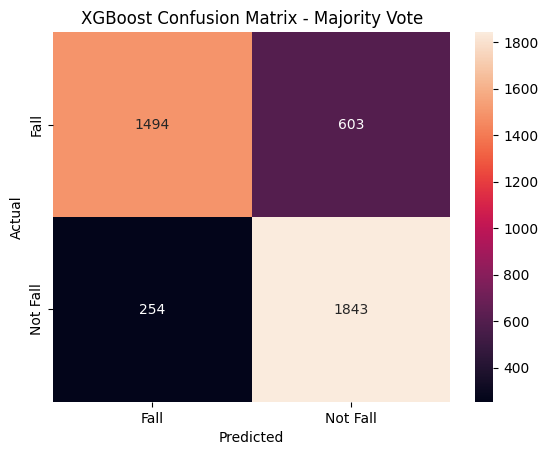

In [13]:
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble, target_names= label_encoder.classes_))

# Confusion Matrix
cm= confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot= True, fmt= 'd', xticklabels= label_encoder.classes_, yticklabels= label_encoder.classes_)
plt.title("XGBoost Confusion Matrix - Majority Vote")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Weighted majority vote

Accuracy: 0.7956604673342871
Classification Report:
               precision    recall  f1-score   support

        Fall       0.85      0.71      0.78      2097
    Not Fall       0.75      0.88      0.81      2097

    accuracy                           0.80      4194
   macro avg       0.80      0.80      0.79      4194
weighted avg       0.80      0.80      0.79      4194



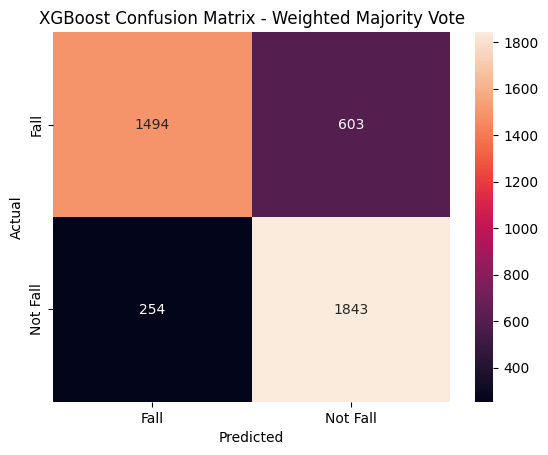

In [14]:
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble_weighted))
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble_weighted, target_names= label_encoder.classes_))

# Confusion Matrix
cm= confusion_matrix(y_test, y_pred_ensemble_weighted)
sns.heatmap(cm, annot= True, fmt= 'd', xticklabels= label_encoder.classes_, yticklabels= label_encoder.classes_)
plt.title("XGBoost Confusion Matrix - Weighted Majority Vote")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()